<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/Corrections_En_passant_Sarah_Cork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

2019.2.0.dev0


In [51]:
import matplotlib.pyplot as plt
import numpy as np

**Energy**
$$
E(u, \alpha):= \frac{1}{2}\int_\Omega 
\underbrace{a(\alpha) E \mathbb{C(\nu)}}_{\sigma(\alpha)} e(u) : e(u) + \frac{G_c}{c_w}\int \frac{\alpha}{\ell}+\ell |\nabla \alpha|^2 dx
$$

where $u = ..., \ell=$

In [ ]:
# Geometry

H1=0.03;
L = 0.06/H1; H = 0.03/H1;
l0 = 0.003/H1; w = 0.005/H1;
L1=(L-w)/2;
L2=(L+w)/2;
H1=H-l0;
epsilon = 0.005; 


plate = Rectangle(Point(0,0), Point(L, H))

notchVertices1 = [Point(L2-epsilon, H), Point(L2 , H1), Point(L2 + epsilon , H)]
notch1 = Polygon(notchVertices1)
notchVertices2 = [Point(L1+epsilon, 0), Point(L1 , l0), Point(L1 - epsilon ,0)]
notch2 = Polygon(notchVertices2)

domain = plate - notch1 - notch2 

cellSize = .00003
nel = H / cellSize
mesh   = generate_mesh(domain, nel)


In [ ]:
 plot(mesh)

In [56]:
ndim = mesh.topology().dim()

cell_mrk = MeshFunction('bool', mesh, ndim)
cell_mrk.set_all(False)

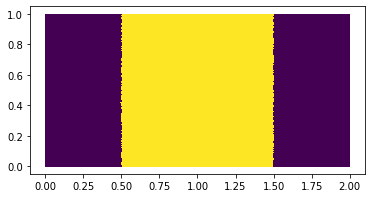

In [57]:
for cell in cells(mesh):
  if 0.5 < cell.midpoint()[0] < 1.5:
    cell_mrk[cell] = True

plot(cell_mrk)

for i in range(2): mesh = refine(mesh, cell_mrk)
# mesh = refine(mesh, cell_mrk)

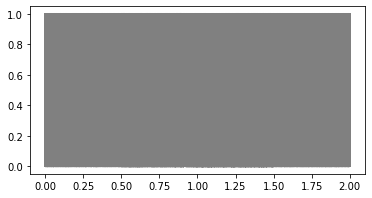

In [58]:
plot(mesh)

In [59]:
V_u = VectorFunctionSpace(mesh, 'CG', 1)
V_alpha = FunctionSpace(mesh, 'CG', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)

alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)

In [60]:
ut = Expression('t', t=0., degree=0)

bcs_u = [DirichletBC(V_u.sub(0), ut, 'near(x[0], {}, 1e-5)'.format(0)), 
         DirichletBC(V_u.sub(0), Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))]


bca_0 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(0))
bca_1 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))

bc_alpha = [bca_0, bca_1]

In [63]:
# Constitutive

# Constitutive functions

E, nu = Constant(10000000.), Constant(0.05)
ell = Constant(0.0000125)

ndim = mesh.topology().dim()

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return (2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim))/E

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

In [64]:
print(f'ell {ell.values()[0]}')
print(f'h min {mesh.hmin():2f}')


ell 1.25e-05
h min 0.000766


In [ ]:
# Energetics

elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy =(w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx

total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

from ufl import replace
E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)

In [ ]:
# Construction of linear and bilinear forms

# problem_u = LinearVariationalProblem()
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bcs_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

# Alternatively, compute explicitly:

A = inner(sigma(alpha, du), eps(v))*dx
# f0, g0 exist in L^2(\Omega), L^2(\partial\Omega)
# LL = dot(f0, v)*dx + dot(g0, v)*ds
zero = project(Constant((0., 0.)), V_u)
LL = dot(zero, v)*dx

problem_u = LinearVariationalProblem(A, LL, u, bcs_u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
# u = TrialFunction(V_u)
ut.t = -10
solver_u.solve()

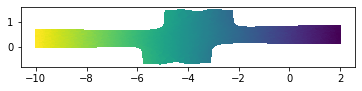

In [ ]:
plot(u, mode='displacement')

In [ ]:
# Bounds

upperbound = project(Constant(1.), V_alpha)
lowerbound = project(Constant(0.), V_alpha)

# Boundary conditions
# set damage = 0 where we impose displacement boundary conditions

# bc_a1 = DirichletBC(V_alpha, Constant(0.), left)
# bc_a2 = DirichletBC(V_alpha, Constant(0.), right)

# bc_a = [bc_a1, bc_a2]

# Nonlinear problem and solver

problem_alpha = NonlinearVariationalProblem(E_alpha, alpha, bc_alpha, J=E_alpha_alpha)
problem_alpha.set_bounds(lowerbound, upperbound)

# solver able to solve with bounds: SNES

solver_alpha = NonlinearVariationalSolver(problem_alpha)
# info(solver_alpha.parameters, True)

snes_solver_parameters_bounds = {"nonlinear_solver": "snes", 
                                 "snes_solver": {"maximum_iterations": 300,
                                                 "absolute_tolerance": 1e-10,
                                                 "relative_tolerance": 1e-5,
                                                 "solution_tolerance": 1e-5,
                                                 "report": True,
                                                 "linear_solver" : "mumps"
                                                 }
                                }
# Solver method  |  Description                                                 
# ------------------------------------------------------------------------------
# bicgstab       |  Biconjugate gradient stabilized method                      
# cg             |  Conjugate gradient method                                   
# default        |  default linear solver                                       
# gmres          |  Generalized minimal residual method                         
# minres         |  Minimal residual method                                     
# mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
# petsc          |  PETSc built in LU solver                                    
# richardson     |  Richardson method                                           
# superlu        |  SuperLU                                                     
# tfqmr          |  Transpose-free quasi-minimal residual method                
# umfpack        |  UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)  

solver_alpha.parameters.update(snes_solver_parameters_bounds)
solver_alpha.solve()



(1, True)

In [ ]:
# boundaries
gauche = CompiledSubDomain("near(x[0], {}, 1e-4)".format(0))
droite = CompiledSubDomain("near(x[0], {}, 1e-4)".format(L))

boundaries = MeshFunction("size_t", mesh, 1)
boundaries.set_all(0)
gauche.mark(boundaries, 1) # mark gauche as 1
droite.mark(boundaries, 2) # mark droite as 2
ds = Measure("ds",subdomain_data=boundaries) # gauche: ds(1), droite: ds(2),


In [ ]:
def alternate_minimisation(alpha, u,
                           alpha_0 = project(Constant(0.), V_alpha),
                           tol=1e-5, maxiter=100):
  alpha_diff = Function(V_alpha)
  iter = 1; error = 1
  alpha.vector()[:] = alpha_0.vector()
  
  while iter < maxiter and error > tol:
    solver_u.solve()
    # u: solution

    solver_alpha.solve()
    # alpha: solution
    # alpha0: alpha at previous timestep

    alpha_diff.vector()[:] = alpha.vector() - alpha_0.vector()
    error = norm(alpha_diff.vector(), 'l2')
    print("Iteration %d, error %e, alpha_max=%.3f"%(iter, error, max(alpha.vector())))
    alpha_0.assign(alpha)

    iter = iter+1

  return (iter, error)

In [ ]:
# alpha = Function(V_alpha)
ut.t = -10.
alternate_minimisation(alpha, u)

Iteration 1, error 5.546712e+01, alpha_max=0.710
Iteration 2, error 1.347111e+01, alpha_max=0.930
Iteration 3, error 2.719729e+01, alpha_max=1.000
Iteration 4, error 2.732711e+01, alpha_max=1.000
Iteration 5, error 1.684827e+01, alpha_max=1.000
Iteration 6, error 7.632007e+00, alpha_max=1.000
Iteration 7, error 2.775478e+00, alpha_max=1.000
Iteration 8, error 5.272451e-01, alpha_max=1.000
Iteration 9, error 2.447425e-01, alpha_max=1.000
Iteration 10, error 1.718438e-01, alpha_max=1.000
Iteration 11, error 1.120595e-01, alpha_max=1.000
Iteration 12, error 4.257587e-02, alpha_max=1.000
Iteration 13, error 1.345129e-02, alpha_max=1.000
Iteration 14, error 2.256020e-04, alpha_max=1.000
Iteration 15, error 2.832227e-04, alpha_max=1.000
Iteration 16, error 3.467009e-04, alpha_max=1.000
Iteration 17, error 4.209844e-04, alpha_max=1.000
Iteration 18, error 4.142898e-04, alpha_max=1.000
Iteration 19, error 2.769958e-04, alpha_max=1.000
Iteration 20, error 1.330211e-04, alpha_max=1.000
Iteration

(24, 1.6664411594877914e-06)

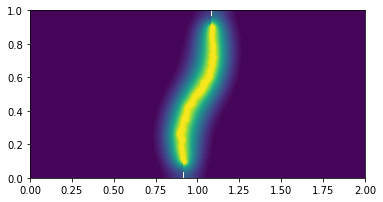

In [ ]:
plot(alpha)

In [ ]:
def postprocess():
    tot_en.append(assemble(total_energy))
    sur_en.append(assemble(dissipated_energy))
    ela_en.append(assemble(elastic_energy))
    # assemble(sigma(alpha, u)[1,1]*ds(1))
    react_gauche.append(assemble(sigma(alpha,u)[1,1]*ds(1)))
    print("** elastic = {:.3f}, surface = {:.3f}, total = {:.3f}"
      .format(ela_en[-1], sur_en[-1], tot_en[-1]))
    print("** Converged in {:d} iterations, error = {:.3f}"
      .format(iter, error))

In [ ]:
import os
import shutil

savedir = "results/plate"
if os.path.isdir(savedir):
    shutil.rmtree(savedir)
    
file_alpha = File(savedir+"/alpha.pvd") 
file_u = File(savedir+"/u.pvd")

In [ ]:
file_u << u

In [ ]:
# Evolution monotonically increasing load

loads = np.linspace(.0, -4, 10)

energies = []

tot_en = []
sur_en = []
ela_en = []
react_gauche = []

for (i, t) in enumerate(loads):
  ut.t = t
  print('')
  print("** Load step: t=%.2f"%t)
  (iter, error) = alternate_minimisation(alpha, u, maxiter=200)
  lowerbound.vector()[:] = alpha.vector()
  # postproc
  postprocess()


energies = {'elastic': ela_en, 'surface': sur_en, 'total': tot_en}


** Load step: t=0.00
Iteration 1, error 0.000000e+00, alpha_max=0.000


NameError: ignored

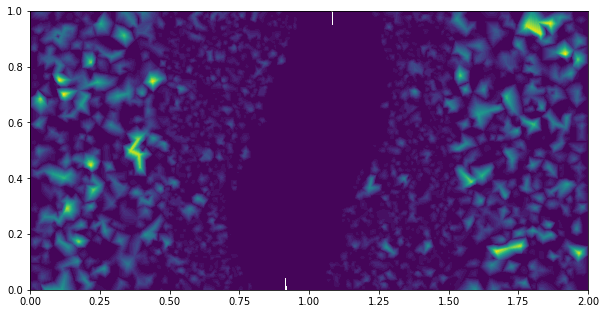

In [ ]:
plt.figure(figsize=(10, 8))
plot(alpha)

ValueError: ignored

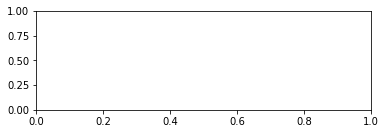

In [ ]:
def plot_stress():
    plt.plot(loads, react_gauche, 'b*', linewidth = 2)
    plt.xlabel('Displacement')
    plt.ylabel('Force')

def plot_energy():
    p1, = plt.plot(loads, energies['elastic'],'b*',linewidth=2)
    p2, = plt.plot(loads, energies['surface'],'r^',linewidth=2)
    p3, = plt.plot(loads, energies['total'],'ko',linewidth=2)
    plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
    plt.xlabel('Displacement')
    plt.ylabel('Energies')


def plot_energy_stress():
    plt.subplot(211)
    plot_stress()
    plt.subplot(212)
    plot_energy()
    plt.savefig('./energies_force.png')
    plt.show()

plot_energy_stress()
